In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [144]:
# RUN THIS CELL

# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.manifold import TSNE

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [ ]:
berlin_wkdy = pd.read_csv("data/berlin_weekdays.csv")
list(berlin_wkdy.columns)

In [5]:
berlin_wknd = pd.read_csv("data/berlin_weekends.csv")
#list(berlin_wknd.columns)

In [137]:
#merging all the dataframes from kaggle into one large data frame 
countries = ['data/amsterdam', 'data/athens', 'data/barcelona', 'data/berlin', 
             'data/budapest', 'data/lisbon',  'data/london', 'data/paris', 'data/rome', 'data/vienna']

types = ['_weekdays.csv', '_weekends.csv']

country_dfs = []

for i in range(0, len(countries)):
    modified_dfs = []
    for j in range(0, 2):
        str = countries[i] + types[j]
        df = pd.read_csv(str)

        if types[j] == '_weekdays.csv':
            df["weekend"] = 0 
        else: 
            df["weekend"] = 1 

        modified_dfs.append(df)
        
    country_full_df = pd.concat(modified_dfs)
    country_full_df['country'] = countries[i][5:]
    country_dfs.append(country_full_df)

all_countries_df = pd.concat(country_dfs)

In [138]:
#scaling the numeric values in the dataframe 
numeric_preds = ['person_capacity', 'cleanliness_rating', 
                 'guest_satisfaction_overall', 'bedrooms', 
                'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 
                 'rest_index','rest_index_norm']

booleans_pred = ['Unnamed: 0', 'realSum', 'room_type', 'room_shared', 'room_private', 'host_is_superhost', 
                'multi', 'biz', 'weekend','country', 'lng', 'lat']
#subset for all categorial variables 
numeric_df = all_countries_df[numeric_preds]
scaler = StandardScaler()
scaled_numeric_df = scaler.fit_transform(numeric_df)
scaled_numeric_df = pd.DataFrame(scaled_numeric_df, columns=numeric_preds)
boolean_df = all_countries_df[booleans_pred]
scaled_numeric_df.reset_index(drop=True, inplace=True)
boolean_df.reset_index(drop=True, inplace=True)
scaled_all_countries = pd.concat([scaled_numeric_df, boolean_df], axis=1)
scaled_all_countries.shape

(51707, 22)

In [139]:
#turning categorial variables into multiple indicator variables

#scaled_all_countries['room_type'].unique()
#dummies = pd.get_dummies(scaled_all_countries.room_type)
 
#all_countries_df_final = pd.concat([scaled_all_countries, dummies], axis='columns')

#all_countries_df_final = merged.drop(['room_type'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['room_type'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['attr_index'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['attr_index_norm'], axis='columns')
scaled_all_countries = scaled_all_countries.drop(['rest_index_norm'], axis='columns')
scaled_all_countries.columns

Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist', 'rest_index', 'Unnamed: 0', 'realSum',
       'room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz',
       'weekend', 'country', 'lng', 'lat'],
      dtype='object')

In [143]:
#calculating covariance 
#col_names = ['realSum', 'room_shared', 'room_private',
#       'person_capacity', 'host_is_superhost', 'multi', 'biz',
#       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
#       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
#       'rest_index_norm', 'lng', 'lat', 'weekend',
#       'Entire home/apt', 'Private room', 'Shared room']
col_names = ['realSum', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist','rest_index','lng', 'lat', 'weekend']
cov_dat = scaled_all_countries[col_names]
corr_matrix = cov_dat.corr()
all_countries_final = scaled_all_countries
all_countries_final.to_csv('countries_cleaned.csv', index=False)

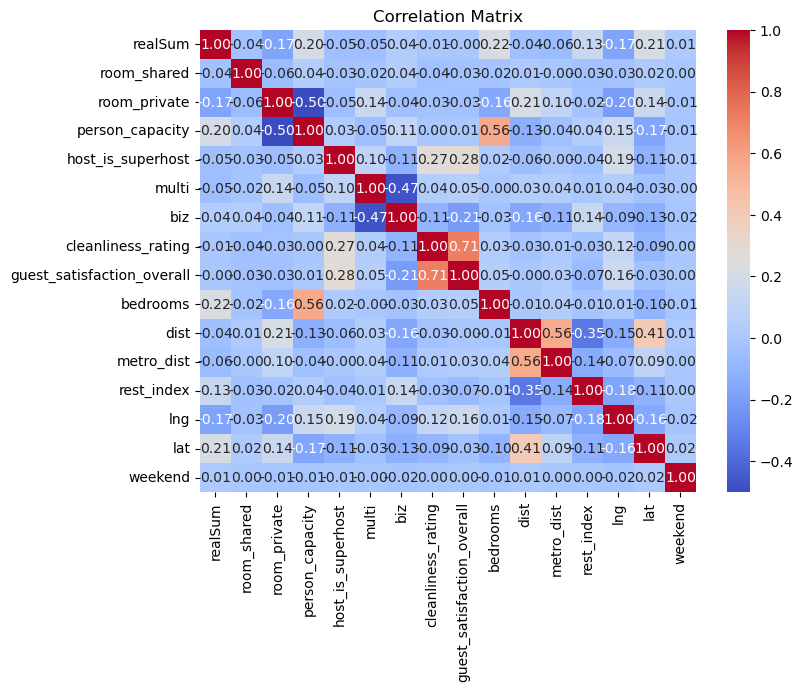

In [141]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300)  # DPI can be adjusted
plt.show()

In [134]:
#applying PCA to the data to visualize data 
country, X = all_countries_final['country'], all_countries_final.drop(columns='country').values
scaler = StandardScaler()
x_std = scaler.fit_transform(X)

pca = PCA(n_components = 2)

# Apply the PCA transformation 
X_transformed = pca.fit_transform(x_std)

# Get the explained variance ratios from the PCA
pca_scores = pca.explained_variance_ratio_

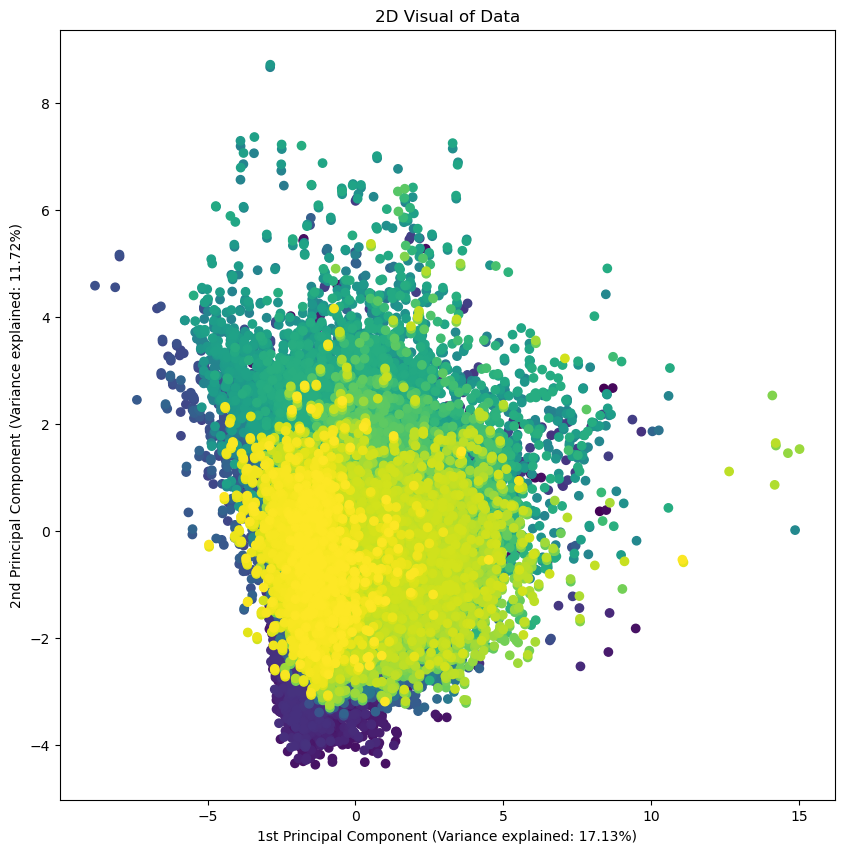

In [135]:
# Create a scatter plot
plt.figure(figsize=(10, 10))

unique_colors = np.arange(len(country))

scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=unique_colors, cmap='viridis')

# Label each point with the country name
#for i, country_name in enumerate(country):
#    plt.annotate(country_name, (X_transformed[i, 0], X_transformed[i, 1]))

# Set labels for the axes including variance explained
plt.xlabel(f'1st Principal Component (Variance explained: {pca_scores[0]*100:.2f}%)')
plt.ylabel(f'2nd Principal Component (Variance explained: {pca_scores[1]*100:.2f}%)')
plt.title('2D Visual of Data')

plt.show()

In [148]:
# Assuming 'data' is your dataset (a pandas DataFrame)
tsne = TSNE(n_components=2)  # n_components defines the output dimensions

col_names = ['room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist','rest_index','lng', 'lat', 'weekend']

X_dat = all_countries_final[col_names]

# Fit and transform the data
tsne_result = tsne.fit_transform(X_dat)

# Converting the result into a DataFrame
tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

(51707, 2)

In [152]:
tsne_df['color'] = all_countries_final['weekend']
tsne_df['country'] = all_countries_final['country']
tsne_df.shape

(51707, 4)

/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

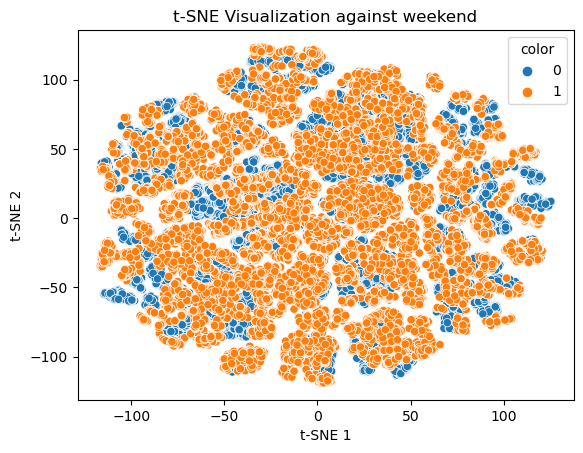

In [155]:
#plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'])
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='color', data=tsne_df)
plt.title('t-SNE Visualization against weekend')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/dinan_elsyad/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

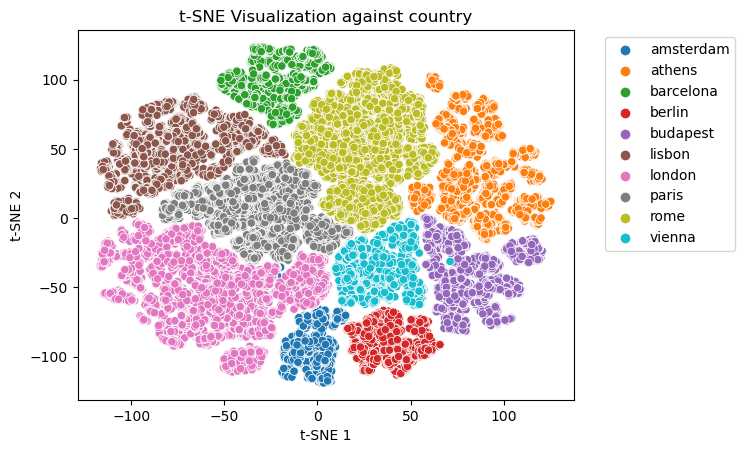

In [154]:
#plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'])
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='country', data=tsne_df)
plt.title('t-SNE Visualization against country')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()